In [88]:
import json
import pennylane as qml
import numpy as np
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

In [89]:
n, m = 2, 4
key = jax.random.PRNGKey(0)
weights = jax.random.uniform(key, (n, m), minval=-2*np.pi, maxval=2*np.pi)

In [90]:
# Entangling layer
def Layer(angles):
    n = len(angles)
    for i in range(n):
        qml.RX(angles[i], wires=i)
    for i in range(n-1):
        qml.CNOT(wires=[i,i+1])
    qml.CNOT(wires=[n-1,0])

In [91]:
n_wires = m
dev = qml.device("default.qubit", wires=n_wires)

@qml.qnode(dev)
def quantum_model(x, weights):
    
    """
    This QNode implements the quantum model with alternating trainable and encoding blocks
    
    Args:
        param_set (np.array): A numpy array whose elements are the parameter matrices for each of the trainable
        blocks. Therefore, the length of this list is equal to the number of trainable blocks, which is greater
        than, or equal to 2.
        g (pennylane.Operator): A PennyLane operator representing the generator for the encoding
        gates. It must be Hermitian in order to generate a unitary.
        x: The scalar coefficient of the operator g.
    Returns:
        (np.tensor(float)): A tensor of dimensions (2,) representing the measurement probabilities in the computational 
        basis on the first wire.
    """

    # Preprocess layer
    for i in range(n_wires):
        qml.RY(jnp.arcsin(x), wires=i)
    for i in range(n_wires):
        qml.RZ(jnp.arccos(x**2), wires=i)
    
    # Trainable layer
    
    n, m = np.shape(weights)
    
    for angles in weights:
        Layer(angles)

    return qml.expval(qml.sum(*[qml.PauliZ(i) for i in range(n_wires)]))


In [92]:
x = 0.1
drawer = qml.draw(quantum_model)
print(drawer(x, weights))

0: ──RY(0.10)──RZ(1.56)──RX(0.40)──╭●───────╭X──RX(-5.01)─╭●───────╭X─┤ ╭<Z+Z+Z+Z>
1: ──RY(0.10)──RZ(1.56)──RX(-1.89)─╰X─╭●────│───RX(6.07)──╰X─╭●────│──┤ ├<Z+Z+Z+Z>
2: ──RY(0.10)──RZ(1.56)──RX(-1.84)────╰X─╭●─│───RX(-3.83)────╰X─╭●─│──┤ ├<Z+Z+Z+Z>
3: ──RY(0.10)──RZ(1.56)──RX(5.69)────────╰X─╰●──RX(4.66)────────╰X─╰●─┤ ╰<Z+Z+Z+Z>


In [93]:
# Define the model
def SinModel(data, weights):
    preds = jnp.array([quantum_model(x, weights) for x in data])

    return preds

In [94]:
# Generate some training data
x_train = jnp.linspace(-1, 1, 10)
y_train = jnp.sin(jnp.pi*x_train)

In [95]:
SinModel(x_train, weights)

Array([0.        , 0.36614817, 0.5797485 , 0.7159027 , 0.7365385 ,
       0.63795567, 0.45604184, 0.26883993, 0.19494885, 0.        ],      dtype=float32)

In [96]:
# Test
key = jax.random.PRNGKey(0)
weights = jax.random.uniform(key, (n, m), minval=-jnp.pi, maxval=jnp.pi)

jnp.mean((SinModel(x_train, weights) - y_train)**2)

Array(0.39518568, dtype=float32)

In [97]:
# Loss function
def loss_fn(weights, data, targets):

    
    return jnp.mean((targets - SinModel(data, weights)) ** 2)

In [98]:
loss_fn(weights, x_train, y_train)

Array(0.39518568, dtype=float32)

In [99]:
# Initialise the model and optimiser
key = jax.random.PRNGKey(1)
params = jax.random.uniform(key, (n, m), minval=0, maxval=2*np.pi)
opt = optax.adam(learning_rate=0.3)
opt_state = opt.init(params)

Step: 0 Loss: 0.3189890384674072
Step: 5 Loss: 0.0521824024617672
Step: 10 Loss: 0.030627673491835594
Step: 15 Loss: 0.03653571754693985
Step: 20 Loss: 0.025411034002900124


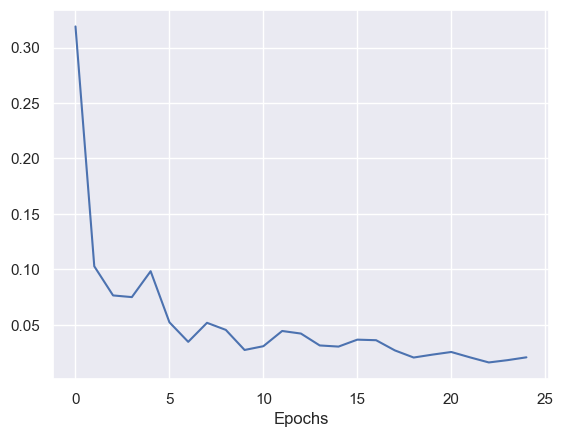

In [100]:
# Define steps
def update_step(opt, params, opt_state, data, targets):
    loss_val, grads = jax.value_and_grad(loss_fn)(params, data, targets)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_val

loss_history = []

for i in range(25):
    params, opt_state, loss_val = update_step(opt, params, opt_state, x_train, y_train)

    if i % 5 == 0:
        print(f"Step: {i} Loss: {loss_val}")

    loss_history.append(loss_val)

sns.set(style='darkgrid')
fig, ax = plt.subplots()
plt.xlabel("Epochs")
plt.ylabel("Loss")
loss_plot = plt.plot(loss_history)
plt.show()

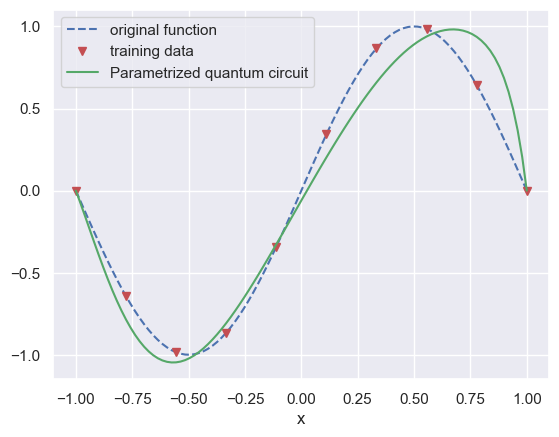

In [101]:
# Evaluate the model
x = jnp.linspace(-1, 1, 100)
sin = jnp.sin(jnp.pi*x)
y_pred = SinModel(x, params)
fig, ax = plt.subplots()
plt.xlabel('x')
plt.plot(x, sin, '--', label='original function')
plt.plot(x_train, y_train, 'rv', label='training data')
plt.plot(x, y_pred, '-g', label='Parametrized quantum circuit')
leg = ax.legend(loc="upper left")
plt.show()

In [102]:
# Optimized parameters
params

Array([[ 2.0472126 ,  5.662075  ,  0.8177751 ,  5.2644286 ],
       [ 4.058689  ,  0.6514216 , -0.81949556,  1.1827468 ]],      dtype=float32)